## Performance of `torch.index_copy_`

Note: this notebook requires JAX nightly 2025 Jun 30 or after to run
successfully, due to certain cloud-side libtpu regression. It also needs
Python 3.11 or later because that is the minimum supported Python version
of JAX as of Jun 30. Check `requirements.txt` for exact reproducibility.

Here is a branch that builds PyTorch/XLA for Python 3.12 and updates libtpu
to Jun 30: https://github.com/pytorch/xla/tree/yifeit/wip-pin-update.

This notebook is meant to be run on a v6e-8 TPU VM.

In [1]:
import os
os.environ['LIBTPU_INIT_ARGS']='--xla_tpu_scoped_vmem_limit_kib=98304 --xla_tpu_use_minor_sharding_for_major_trivial_input=true --xla_tpu_relayout_group_size_threshold_for_reduce_scatter=1 --xla_tpu_assign_all_reduce_scatter_layout=true --xla_tpu_enable_data_parallel_all_reduce_opt=true --xla_tpu_data_parallel_opt_different_sized_ops=true --xla_tpu_enable_async_collective_fusion=true --xla_tpu_enable_async_collective_fusion_fuse_all_gather=true --xla_tpu_enable_async_collective_fusion_multiple_steps=true  --xla_tpu_overlap_compute_collective_tc=true  --xla_enable_async_all_gather=true --xla_tpu_enable_async_collective_fusion_fuse_all_reduce=false  --xla_tpu_enable_sparse_core_collective_offload_all_reduce=true --xla_tpu_use_tc_device_shape_on_sc=true  --xla_sc_disable_megacore_partitioning=true  --2a886c8_chip_config_name=megachip_tccontrol'

In [2]:
import torch_xla

print(torch_xla.devices())

/home/yifeit/torch/playground/pallas/.venv/lib/python3.12/site-packages/torch_xla/__init__.py:258: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(


[device(type='xla', index=0), device(type='xla', index=1), device(type='xla', index=2), device(type='xla', index=3), device(type='xla', index=4), device(type='xla', index=5), device(type='xla', index=6), device(type='xla', index=7)]


`torch.index_copy_` is used in vLLM pallas attention layers to copy the key and
value vectors generated during the forward pass of one scheduling step into the
KV cache.

```py
def write_to_kv_cache(
    key: torch.Tensor,
    value: torch.Tensor,
    kv_cache: torch.Tensor,
    slot_mapping: torch.Tensor,
) -> None:
    """Write the key and values to the KV cache.

    Args:
        key: shape = [num_tokens, num_kv_heads * head_size]
        value: shape = [num_tokens, num_kv_heads *  head_size]
        kv_cache = [num_blocks, block_size, num_kv_heads * 2, head_size]
        slot_mapping = [num_tokens]

    """
    _, _, num_combined_kv_heads, head_size = kv_cache.shape
    head_size = cdiv(head_size,
                     TPU_HEAD_SIZE_ALIGNMENT) * TPU_HEAD_SIZE_ALIGNMENT
    kv = torch.cat([key, value], axis=-1).reshape(-1, num_combined_kv_heads,
                                                  head_size)

    torch.ops.xla.dynamo_set_buffer_donor_(kv_cache, True)

    kv_cache = kv_cache.flatten(0, 1)
    kv_cache.index_copy_(0, slot_mapping, kv)
```

`slot_mapping` might look like:

```py
torch.Size([16]) tensor([64, 65, 66, 67, 68, 69, 70, 71, 72, 1000000000, 1000000000, ...])
```

which indicates a light prefill step involving 9 valid tokens, or

```py
torch.Size([256]) tensor([73, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
                          192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203,
                          256, 257, 258, 259, 260, 261, 262, 263, 264, 265, ...])
```

which indicates a heavy mixed prefill and decode step processing 256 tokens, or

```py
torch.Size([16]) tensor([74, 141, 204, 485, 1000000000, 1000000000, ...])
```

which indicates a light decode step generating 4 new tokens for 4 requests, etc.

`1000000000` is an out-of-bounds sentinel value that indicates that particular
token slot is unused.

In `google/gemma-3-27b-it` over 8 chips via tensor parallelism, the KV cache has
a shape of `bf16[5607,64,4,128]` (flattened to `bf16[358848,4,128]`). Gemma 3 has
16+16=32 KV heads but that's sharded over 8 chips, so each chip stores 4 heads.

In vLLM TPU, the number of tokens processed by each scheduling step is
configurable. In benchmarks, `--max-num-batched-tokens=2048` so we may write up
to 2048 token KV caches at once.

We will now benchmark the HBM throughput of a scattered copy of 2048 tokens on
a v6e chip.

In [3]:
import numpy as np
import torch
import torch_xla.core.xla_model as xm
import torch_xla.debug.profiler as xp
from xprof_step_time.step_duration import step_duration_from_latest_profile

NUM_TOKENS_BENCH = 2048
KV_CACHE_NUM_BLOCKS = 5607

def index_copy(kv_cache, new_kv, slot_mapping):
  assert new_kv.shape[0] == slot_mapping.shape[0]
  assert new_kv.shape[1:] == kv_cache.shape[2:]
  torch.ops.xla.dynamo_set_buffer_donor_(kv_cache, True)
  kv_cache.flatten(0, 1).index_copy_(0, slot_mapping, new_kv)

@torch.compile(backend='openxla')
def benchmark_step(kv_cache, new_kv, slot_mapping):
  index_copy(kv_cache, new_kv, slot_mapping)

def benchmark_index_copy(num_heads=4):
  # Create a slot mapping of size NUM_TOKENS_BENCH.
  slot_mapping = torch.from_numpy(np.arange(NUM_TOKENS_BENCH, dtype=np.uint32)).long().to('xla')

  # Create a KV cache with KV_CACHE_NUM_BLOCKS blocks, each with 64 token slots.
  BLOCK_SIZE = 64
  HEAD_SIZE = 128
  kv_cache = torch.rand((KV_CACHE_NUM_BLOCKS, BLOCK_SIZE, num_heads, HEAD_SIZE), dtype=torch.bfloat16).to('xla')

  # Benchmark index_copy performance.
  new_kv = torch.rand((NUM_TOKENS_BENCH, num_heads, HEAD_SIZE), dtype=torch.bfloat16).to('xla')

  # Warm up
  def run_warmup():
    for i in range(2):
      benchmark_step(kv_cache, new_kv, slot_mapping)
      torch_xla.sync(wait=True)
      xm.wait_device_ops()

  run_warmup()

  # Benchmark
  PROFILE_DIR = 'profile/index_copy'
  os.makedirs(PROFILE_DIR, exist_ok=True)

  def run_benchmark():
    torch_xla.sync(wait=True)
    xm.wait_device_ops()
    NUM_STEPS = 200
    xp.start_trace(PROFILE_DIR)
    for i in range(NUM_STEPS):
      benchmark_step(kv_cache, new_kv, slot_mapping)
    torch_xla.sync(wait=True)
    xm.wait_device_ops()
    xp.stop_trace()
    step_time = step_duration_from_latest_profile(PROFILE_DIR, ignore_gaps=True, verbose=False)
    bytes_copied = new_kv.numel() * new_kv.element_size()
    print(f"Execution took {step_time * 1000:.4f} ms. Bytes copied: {bytes_copied} bytes.")
    throughput = bytes_copied / step_time
    print(f"Throughput: {throughput / 1e9:.2f} GB/s.")
    import gc; gc.collect()  # noqa: E402, E702
    return throughput

  return run_benchmark()

throughput_4 = benchmark_index_copy(num_heads=4)

Execution took 0.1748 ms. Bytes copied: 2097152 bytes.
Throughput: 11.99 GB/s.


Let's try hypothetical scenarios with more KV heads.

In [4]:
throughputs = [throughput_4]
num_heads = [4]
for num_head in [8, 16, 32, 64]:
  print(f"Benchmarking with {num_head} heads...")
  throughput = benchmark_index_copy(num_heads=num_head)
  throughputs.append(throughput)
  num_heads.append(num_head)

num_heads = np.array(num_heads)
throughputs = np.array(throughputs) / 1e9  # Convert to GB/s

Benchmarking with 8 heads...
Execution took 0.1773 ms. Bytes copied: 4194304 bytes.
Throughput: 23.66 GB/s.
Benchmarking with 16 heads...
Execution took 0.2010 ms. Bytes copied: 8388608 bytes.
Throughput: 41.73 GB/s.
Benchmarking with 32 heads...
Execution took 0.2158 ms. Bytes copied: 16777216 bytes.
Throughput: 77.75 GB/s.
Benchmarking with 64 heads...
Execution took 0.2486 ms. Bytes copied: 33554432 bytes.
Throughput: 134.96 GB/s.


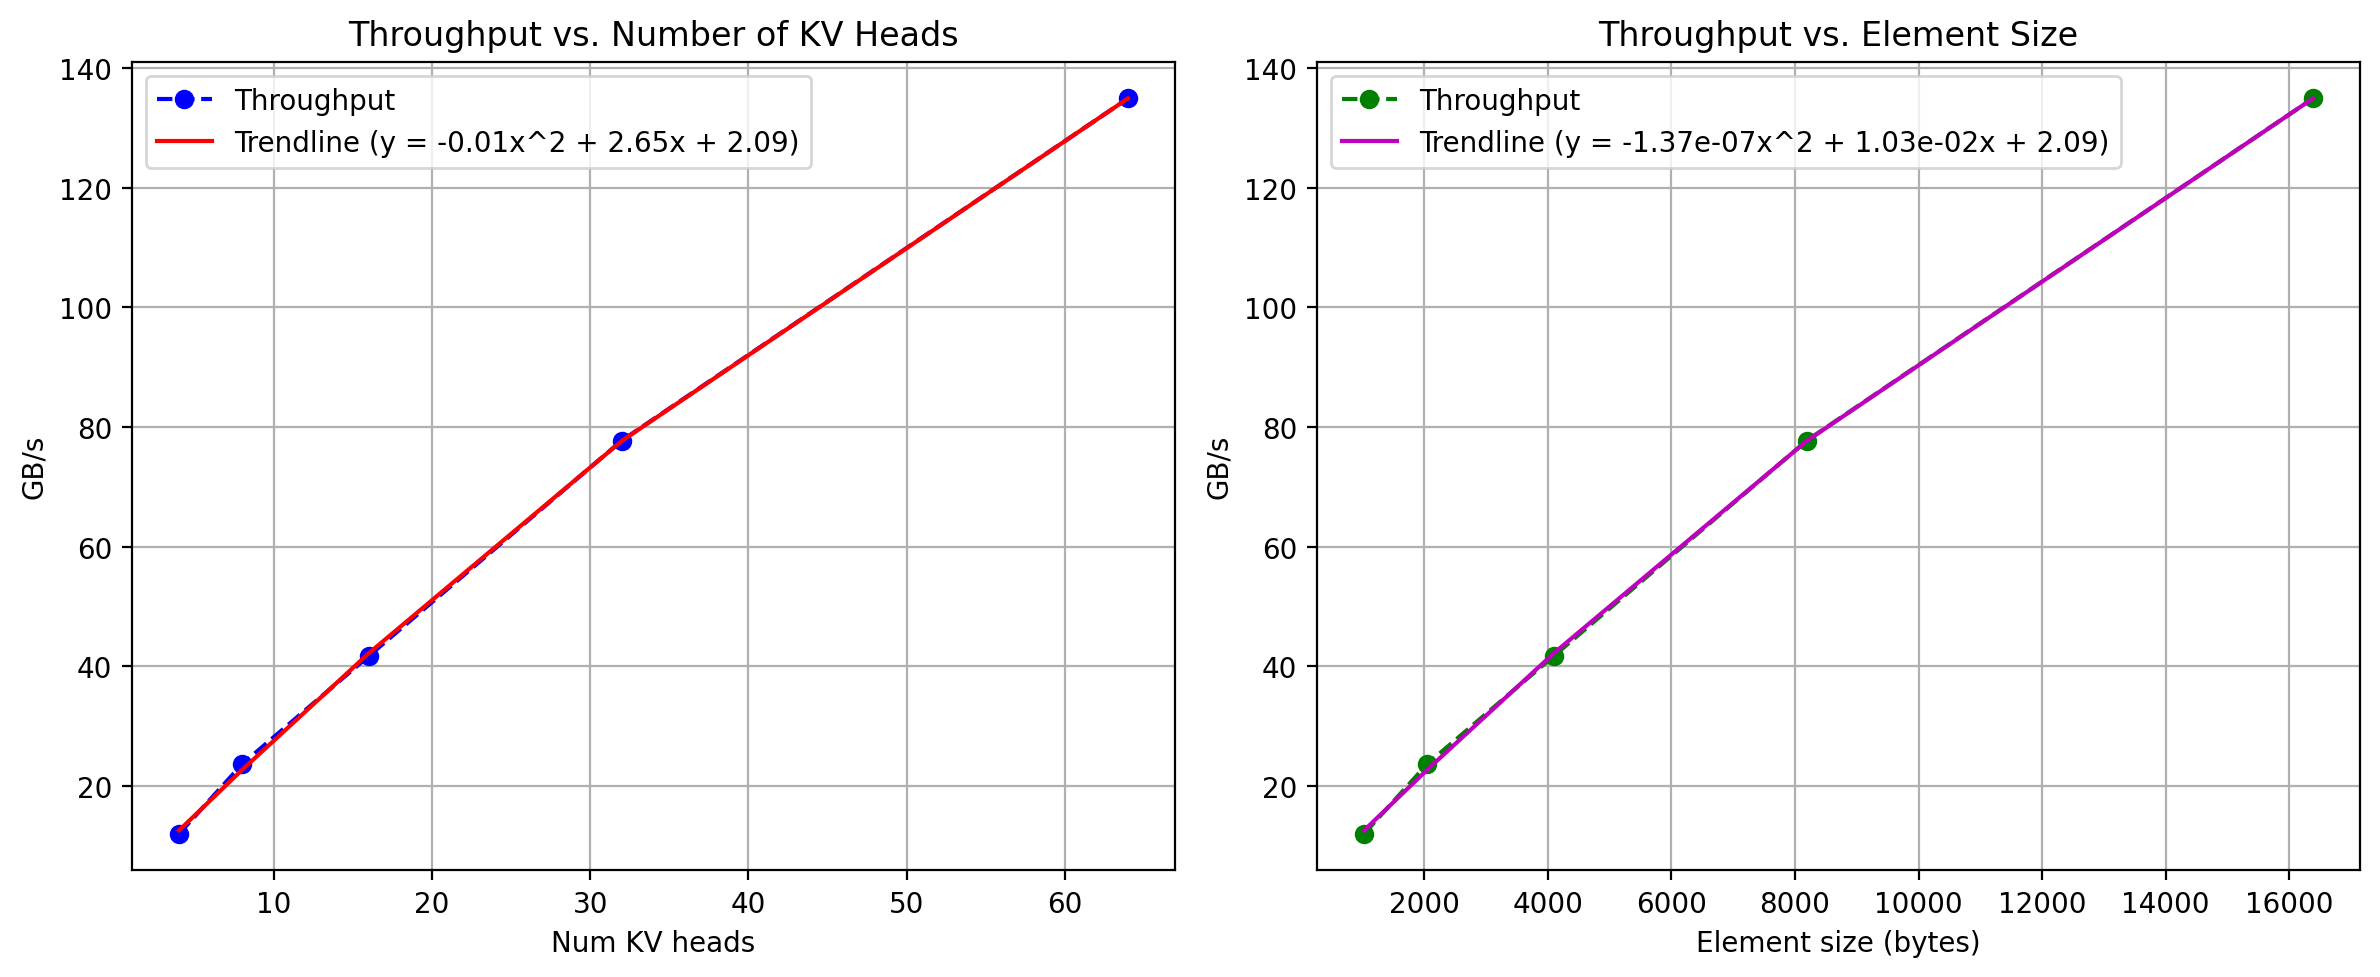

In [5]:
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# --- First subplot: Throughput vs. Number of KV Heads ---
coeffs1 = np.polyfit(num_heads, throughputs, 2)
fitted1 = np.poly1d(coeffs1)
ax1.plot(num_heads, throughputs, 'bo--', label='Throughput')
ax1.plot(num_heads, fitted1(num_heads), 'r-', label=f'Trendline (y = {coeffs1[0]:.2f}x^2 + {coeffs1[1]:.2f}x + {coeffs1[2]:.2f})')
ax1.set_title('Throughput vs. Number of KV Heads')
ax1.set_ylabel('GB/s')
ax1.set_xlabel('Num KV heads')
ax1.legend()
ax1.grid(True)

# --- Second subplot: Throughput vs. Element Size ---
element_size = num_heads * 128 * 2  # in bytes

coeffs2 = np.polyfit(element_size, throughputs, 2)
fitted2 = np.poly1d(coeffs2)
ax2.plot(element_size, throughputs, 'go--', label='Throughput')
# Using scientific notation for coefficients as they can be very small
ax2.plot(element_size, fitted2(element_size), 'm-', label=f'Trendline (y = {coeffs2[0]:.2e}x^2 + {coeffs2[1]:.2e}x + {coeffs2[2]:.2f})')
ax2.set_title('Throughput vs. Element Size')
ax2.set_ylabel('GB/s')
ax2.set_xlabel('Element size (bytes)')
ax2.legend()
ax2.grid(True)

# Adjust layout to prevent titles/labels from overlapping and show the plot
plt.tight_layout()
plt.show()

## Observations

The `index_copy_` operation is lowered to an XLA `scatter` operation.

![index copy hlo](./index-copy-hlo.png)

We're not sure how `scatter` is implemented. However, it's clear that throughput
suffers when each element to be scattered is small. When copying `bf16[4, 128]`
elements, the throughput is only 12 GB/s. Throughput more or less scales linearly
with element size, modulo a small `-0.01x^2` overhead factor. For every KB of
scatter element size increase, throughput increases by 10.2 GB.

For reference, v6e HBM bandwidth is 1640 GB/s. Even considering that `scatter`
might be reading `new_kv` into VMEM and then writing it back to HBM, thus
generating twice the traffic, we are still far from hitting peak HBM bandwidth.

## Prototype faster copy

Let's create a toy Pallas kernel that copies the key value vectors for multiple
elements in one program instance, and see how fast it can be.

In [6]:
import jax
import jax.numpy as jnp
from jax.experimental import pallas as pallas
import numpy as np
import gc
from xprof_step_time.step_duration import step_duration_from_latest_profile  # noqa: F811

NUM_HEADS = 4

def copy_kernel(x_ref, y_ref):
  y_ref[...] = x_ref[...]

def pallas_copy(x: jax.Array, copy_num_tokens: int, num_heads: int, debug: bool) -> jax.Array:
  out_shape = jax.ShapeDtypeStruct(x.shape, x.dtype)
  spec = pallas.BlockSpec((copy_num_tokens, num_heads, 128,), lambda i: (i, 0, 0))

  y = pallas.pallas_call(
      copy_kernel,
      out_shape=out_shape,
      grid=(x.shape[0] // copy_num_tokens,),
      in_specs=[spec],
      out_specs=spec,
      debug=debug,
  )(x)
  return y


# Create some test data
array_size = (NUM_TOKENS_BENCH, NUM_HEADS, 128)
x_device = jnp.arange(np.prod(array_size), dtype=jnp.bfloat16).reshape(array_size)

jitted_pallas_copy = jax.jit(pallas_copy, static_argnames=('copy_num_tokens', 'num_heads', 'debug'))
y_device = jitted_pallas_copy(x_device, copy_num_tokens=128, num_heads=NUM_HEADS, debug=True)

# Verify the result
print(f"Input and output arrays are close: {jnp.allclose(x_device, y_device)}")
print(f"Input shape: {x_device.shape}, Output shape: {y_device.shape}")
print(f"Input dtype: {x_device.dtype}, Output dtype: {y_device.dtype}")


# Benchmark the performance
def run_benchmark(x_device, copy_num_tokens=128):
  gc.collect()
  all_outputs = []
  jax.block_until_ready(jax.live_arrays())
  NUM_STEPS = 200
  PROFILE_DIR = 'profile/index_copy_pallas'
  os.makedirs(PROFILE_DIR, exist_ok=True)
  jax.profiler.start_trace(PROFILE_DIR)
  for i in range(NUM_STEPS):
    all_outputs.append(jitted_pallas_copy(x_device, copy_num_tokens=copy_num_tokens, num_heads=NUM_HEADS, debug=False))
  jax.block_until_ready(all_outputs)
  jax.profiler.stop_trace()
  step_time = step_duration_from_latest_profile(PROFILE_DIR, ignore_gaps=True, verbose=False)
  bytes_copied = all_outputs[-1].size * all_outputs[-1].dtype.itemsize
  print(f"Execution took {step_time * 1000:.4f} ms. Bytes copied: {bytes_copied} bytes.")
  throughput = bytes_copied / step_time
  print(f"Throughput: {throughput / 1e9:.2f} GB/s.")
  return throughput

toy_pallas_num_tokens = [1, 2, 4, 8, 16, 32, 64, 128]
toy_pallas_throughput = []
for copy_num_tokens in toy_pallas_num_tokens:
  print(f"Running benchmark with copy_num_tokens={copy_num_tokens}...")
  throughput = run_benchmark(x_device, copy_num_tokens=copy_num_tokens)
  toy_pallas_throughput.append(throughput / 1e9)  # Convert to GB/s
  gc.collect()
del x_device, y_device
gc.collect()


The kernel jaxpr for pallas_call copy_kernel at /tmp/ipykernel_1056233/3118407247.py:10:
{ lambda ; a:MemRef<None>{bfloat16[128,4,128]} b:MemRef<None>{bfloat16[128,4,128]}. let
    c:bf16[128,4,128] <- a[:,:,:]
    b[:,:,:] <- c
  in () }

The Mosaic module for pallas_call copy_kernel at /tmp/ipykernel_1056233/3118407247.py:10:
module @copy_kernel {
  func.func @main(%arg0: i32, %arg1: memref<128x4x128xbf16, #tpu.memory_space<vmem>>, %arg2: memref<128x4x128xbf16, #tpu.memory_space<vmem>>) attributes {dimension_semantics = [#tpu.dimension_semantics<arbitrary>], iteration_bounds = array<i64: 16>, scalar_prefetch = 0 : i64, scratch_operands = 0 : i64, window_params = [{transform_indices = @transform_0, window_bounds = array<i64: 128, 4, 128>}, {transform_indices = @transform_1, window_bounds = array<i64: 128, 4, 128>}]} {
    %c0 = arith.constant 0 : index
    %c0_0 = arith.constant 0 : index
    %c0_1 = arith.constant 0 : index
    %0 = vector.load %arg1[%c0, %c0_0, %c0_1] : memref<128x

2025-07-01 20:14:49.308394: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751426089.318005 1056233 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751426089.320802 1056233 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751426089.331966 1056233 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751426089.331983 1056233 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751426089.331985 1056233 computation_placer.cc:177] computation placer alr

Execution took 0.6497 ms. Bytes copied: 2097152 bytes.
Throughput: 3.23 GB/s.
Running benchmark with copy_num_tokens=2...
Execution took 0.3362 ms. Bytes copied: 2097152 bytes.
Throughput: 6.24 GB/s.
Running benchmark with copy_num_tokens=4...
Execution took 0.1743 ms. Bytes copied: 2097152 bytes.
Throughput: 12.03 GB/s.
Running benchmark with copy_num_tokens=8...
Execution took 0.0908 ms. Bytes copied: 2097152 bytes.
Throughput: 23.10 GB/s.
Running benchmark with copy_num_tokens=16...
Execution took 0.0476 ms. Bytes copied: 2097152 bytes.
Throughput: 44.06 GB/s.
Running benchmark with copy_num_tokens=32...
Execution took 0.0259 ms. Bytes copied: 2097152 bytes.
Throughput: 81.12 GB/s.
Running benchmark with copy_num_tokens=64...
Execution took 0.0146 ms. Bytes copied: 2097152 bytes.
Throughput: 143.79 GB/s.
Running benchmark with copy_num_tokens=128...
Execution took 0.0090 ms. Bytes copied: 2097152 bytes.
Throughput: 234.29 GB/s.


0

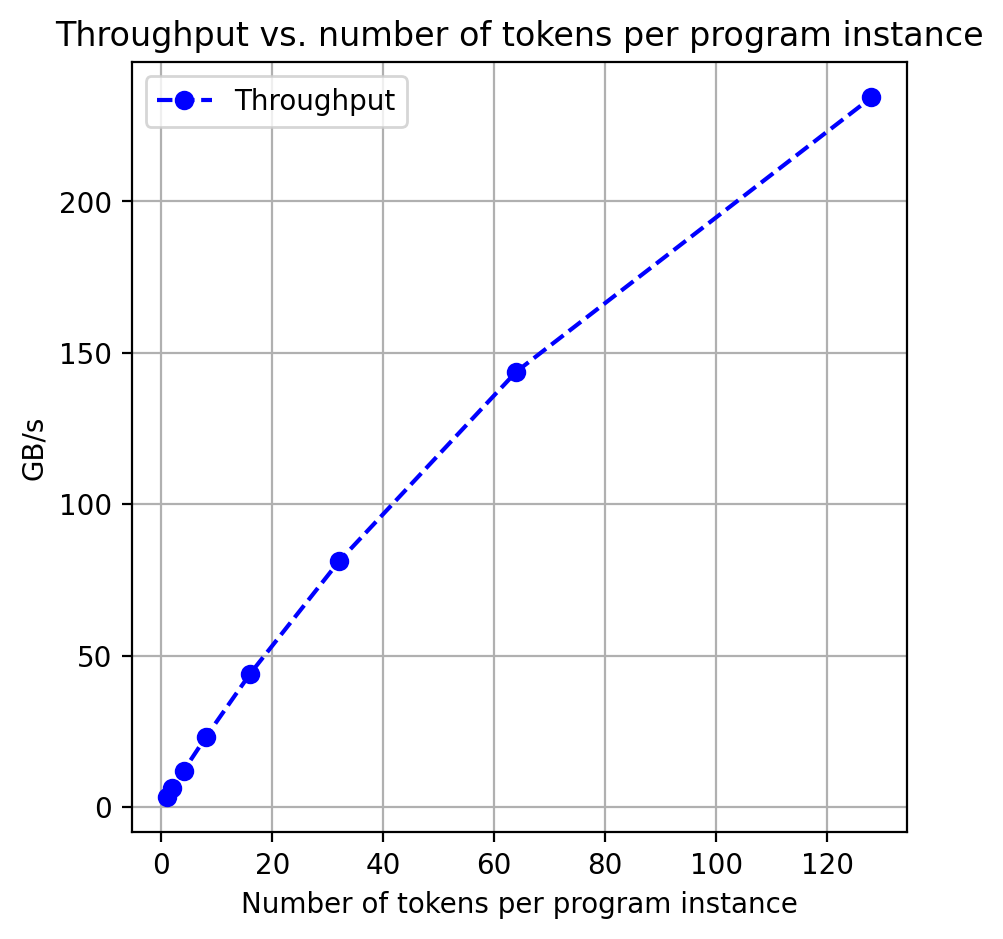

In [7]:
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

fig, ax1 = plt.subplots(1, 1, figsize=(5, 5))

ax1.plot(toy_pallas_num_tokens, toy_pallas_throughput, 'bo--', label='Throughput')
ax1.set_title('Throughput vs. number of tokens per program instance')
ax1.set_ylabel('GB/s')
ax1.set_xlabel('Number of tokens per program instance')
ax1.legend()
ax1.grid(True)

That confirms that in the ideal case, we can easily beat `scatter` throughput
with up to 20x speedup.

Now the tricky part is figuring out how to dynamically exploit the contiguity
in the slot mapping in case of prefill, while still handling the discontiguous
slot indices in case of decode.

## Asynchronous HBM copy

Can we start 2048 asynchronous DMAs, each handling the KV for one token?

This will potentially let us copy each token to a different location, depending
on the slot mapping.

In [8]:
from typing import Any
from jax.experimental import pallas as pl
from jax.experimental.pallas import tpu as pltpu

Future = Any

def make_async_copy(target_memory_space=pltpu.ANY, copy_num_tokens: int=1):
  @jax.named_call
  def async_copy_start(x: jax.Array) -> tuple[jax.Array, Future]:

    def copy_start_kernel(x_ref, aliased_x_ref, o_ref, sem):
      del aliased_x_ref
      pltpu.make_async_copy(x_ref.at[pl.program_id(0)], o_ref.at[pl.program_id(0)], sem).start()

    x, out, sem = pl.pallas_call(
        copy_start_kernel,
        out_shape=(
            jax.ShapeDtypeStruct(x.shape, x.dtype),  # aliased x
            target_memory_space(x.shape, x.dtype),  # out
            pltpu.SemaphoreType.DMA(()),  # sem
        ),
        grid=(x.shape[0] // copy_num_tokens,),
        in_specs=[
            pl.BlockSpec(memory_space=pltpu.ANY),
        ],
        out_specs=(
            pl.BlockSpec(memory_space=pltpu.ANY),
            pl.BlockSpec(memory_space=target_memory_space),
            pl.BlockSpec(memory_space=pltpu.SEMAPHORE),
        ),
        input_output_aliases={0: 0},
    )(x)
    return x, (out, sem)

  @jax.named_call
  def async_copy_done(x: jax.Array, future: Future) -> jax.Array:
    out, sem = future

    def copy_done_kernel(x_ref, o_ref, sem, aliased_o_ref):
      del aliased_o_ref
      pltpu.make_async_copy(x_ref.at[pl.program_id(0)], o_ref.at[pl.program_id(0)], sem).wait()

    out = pl.pallas_call(
        copy_done_kernel,
        out_shape=target_memory_space(x.shape, x.dtype),  # out
        grid=(x.shape[0] // copy_num_tokens,),
        in_specs=[
            pl.BlockSpec(memory_space=pltpu.ANY),
            pl.BlockSpec(memory_space=target_memory_space),
            pl.BlockSpec(memory_space=pltpu.SEMAPHORE),
        ],
        out_specs=pl.BlockSpec(memory_space=target_memory_space),
        input_output_aliases={1: 0},
    )(x, out, sem)
    return out

  return async_copy_start, async_copy_done

@jax.jit
def toy_async_copy(x):
  copy_start, copy_done = make_async_copy()
  x, fut = copy_start(x)
  y = copy_done(x, fut)
  return y

array_size = (NUM_TOKENS_BENCH, NUM_HEADS, 128)
x_device = jnp.arange(np.prod(array_size), dtype=jnp.bfloat16).reshape(array_size)
y_device = toy_async_copy(x_device)

# Verify the result
print(f"Input and output arrays are close: {jnp.allclose(x_device, y_device)}")
print(f"Input shape: {x_device.shape}, Output shape: {y_device.shape}")
print(f"Input dtype: {x_device.dtype}, Output dtype: {y_device.dtype}")

# Benchmark the performance
def run_benchmark_async(x_device) -> float:
  gc.collect()
  all_outputs = []
  jax.block_until_ready(jax.live_arrays())
  NUM_STEPS = 200
  PROFILE_DIR = 'profile/index_copy_pallas'
  os.makedirs(PROFILE_DIR, exist_ok=True)
  jax.profiler.start_trace(PROFILE_DIR)
  for i in range(NUM_STEPS):
    all_outputs.append(toy_async_copy(x_device))
  jax.block_until_ready(all_outputs)
  jax.profiler.stop_trace()
  step_time = step_duration_from_latest_profile(PROFILE_DIR, ignore_gaps=True, verbose=False)
  bytes_copied = all_outputs[-1].size * all_outputs[-1].dtype.itemsize
  print(f"Execution took {step_time * 1000:.4f} ms. Bytes copied: {bytes_copied} bytes.")
  throughput = bytes_copied / step_time
  print(f"Throughput: {throughput / 1e9:.2f} GB/s.")
  return throughput

run_benchmark_async(x_device)
del x_device, y_device
import gc; gc.collect()  # noqa: E402, E702

Input and output arrays are close: True
Input shape: (2048, 4, 128), Output shape: (2048, 4, 128)
Input dtype: bfloat16, Output dtype: bfloat16
Execution took 0.0428 ms. Bytes copied: 2097152 bytes.
Throughput: 48.97 GB/s.


0

This shows that we can still 4x the throughput by issuing tons of small DMAs.

## Asynchronous index copy

Can we take our async copy kernel and have each program instance operate on the
corresponding slot mapping index?

The first challenge is constructing a Pallas kernel that mutates an array
in-place. Let's try to write a Pallas kernel that adds 1 to every element of
an input array.

In [9]:
from functools import partial
import gc; gc.collect()  # noqa: E402, E702


@jax.named_call
def add_one_kernel(x_ref, aliased_x_ref):
  # input_output_aliases have confusing semantics,
  # the aliasing only happens in HBM, but not in VMEM.
  # This is a compiler limitation.
  #
  # So x_ref and aliased_x_ref are not the same VMEM reference.
  # We still need to read from x_ref, then write to aliased_x_ref.
  #
  # Pallas will ensure correct aliasing in HBM (i.e., our writes to aliased_x_ref will
  # materialize in the same HBM location as x_ref).
  o = x_ref[...] + 1
  aliased_x_ref[...] = o


@partial(jax.jit, donate_argnums=(0,))
@jax.named_call
def add_one(x: jax.Array) -> jax.Array:
  add_block_size = 1024
  return pl.pallas_call(
      add_one_kernel,
      out_shape=jax.ShapeDtypeStruct(x.shape, x.dtype),
      grid=(x.shape[0] // add_block_size,),
      in_specs=[
          pl.BlockSpec((add_block_size,), lambda i: i, memory_space=pltpu.VMEM),
      ],
      out_specs=pl.BlockSpec((add_block_size,), lambda i: i, memory_space=pltpu.VMEM),
      input_output_aliases={0: 0},
  )(x)


# Test the add_one function
x = jnp.arange(1024, dtype=jnp.bfloat16)
old_pointer = x.addressable_data(0).unsafe_buffer_pointer()
x = add_one(x)
print(x)
new_pointer = x.addressable_data(0).unsafe_buffer_pointer()
assert jnp.all(x == 1 + jnp.arange(1024, dtype=jnp.bfloat16)), "add_one did not work as expected"
assert old_pointer == new_pointer, "add_one did not preserve the buffer pointer"

# Let's allocate a 17 GiB array and see if we can add 1 to it.
# If the aliasing machinery doesn't work, we will run out of HBM.
array_size = (17 * 1024 * 1024 * 1024 // 2)
x = jnp.arange(array_size, dtype=jnp.bfloat16)
old_pointer = x.addressable_data(0).unsafe_buffer_pointer()
x = add_one(x)
print(x)
new_pointer = x.addressable_data(0).unsafe_buffer_pointer()
assert jnp.all(x[:1024] == 1 + jnp.arange(1024, dtype=jnp.bfloat16)), "add_one did not work as expected"
assert old_pointer == new_pointer, "add_one did not preserve the buffer pointer"

del x
import gc; gc.collect()  # noqa: E402, E702

[1 2 3 ... 1020 1024 1024]
[1 2 3 ... 5.36871e+08 5.36871e+08 5.36871e+08]


0

In [10]:
# Implements the equivalent of
#
# def index_copy(kv_cache, new_kv, slot_mapping):
#   assert new_kv.shape[0] == slot_mapping.shape[0]
#   assert new_kv.shape[1:] == kv_cache.shape[2:]
#   torch.ops.xla.dynamo_set_buffer_donor_(kv_cache, True)
#   kv_cache.flatten(0, 1).index_copy_(0, slot_mapping, new_kv)
#
# The overall strategy is to preload the slot_mapping into SRAM.
# Then we can use the slot_mapping to index into the kv_cache.

@partial(jax.jit, donate_argnums=(0,))
@jax.named_call
def pallas_index_copy(kv_cache: jax.Array, new_kv: jax.Array, slot_mapping: jax.Array) -> jax.Array:
  """Any new_kv tokens will be copied to the kv_cache at the indices specified by slot_mapping.

  kv_cache shape: [num_blocks, block_size, num_heads, head_size]

  The input kv_cache will be consumed, and the updated kv_cache will be returned.
  """
  assert new_kv.shape[0] == slot_mapping.shape[0], "new_kv and slot_mapping must have the same first dimension"
  assert new_kv.shape[1:] == kv_cache.shape[2:], "new_kv shape must match kv_cache shape except for the first dimension"

  num_blocks = kv_cache.shape[0]
  block_size = kv_cache.shape[1]
  flat_kv_cache = kv_cache.reshape(-1, *kv_cache.shape[2:])

  new_kv, fut = index_copy_start(new_kv, flat_kv_cache, slot_mapping)
  flat_kv_cache = index_copy_done(new_kv, flat_kv_cache, slot_mapping, fut)

  return flat_kv_cache.reshape(num_blocks, block_size, *kv_cache.shape[2:])


COPY_NUM_STEPS = 1


@jax.named_call
def index_copy_start(x: jax.Array, kv_cache: jax.Array, slot_mapping: jax.Array) -> tuple[jax.Array, Future]:

  def copy_start_kernel(slot_mapping, x_ref, aliased_o_ref, aliased_x_ref, o_ref, sem):
    del aliased_x_ref
    pltpu.make_async_copy(x_ref.at[pl.program_id(0)], o_ref.at[slot_mapping[pl.program_id(0)]], sem).start()

  x = pltpu.with_memory_space_constraint(x, pltpu.HBM)
  kv_cache = pltpu.with_memory_space_constraint(kv_cache, pltpu.HBM)

  x, out, sem = pl.pallas_call(
      copy_start_kernel,
      out_shape=(
          pltpu.HBM(x.shape, x.dtype),  # aliased x
          pltpu.HBM(kv_cache.shape, kv_cache.dtype),  # out
          pltpu.SemaphoreType.DMA(()),  # sem
      ),
      grid_spec=pltpu.PrefetchScalarGridSpec(
        num_scalar_prefetch=1,
        grid=(x.shape[0] // COPY_NUM_STEPS,),
        in_specs=[
            pl.BlockSpec(memory_space=pltpu.ANY),  # x
            pl.BlockSpec(memory_space=pltpu.ANY),  # kv_cache
        ],
        out_specs=(
            pl.BlockSpec(memory_space=pltpu.ANY),
            pl.BlockSpec(memory_space=pltpu.ANY),
            pl.BlockSpec(memory_space=pltpu.SEMAPHORE),
        ),
      ),
      input_output_aliases={1: 0, 2: 1},
  )(slot_mapping, x, kv_cache)
  return x, (out, sem)

@jax.named_call
def index_copy_done(x: jax.Array, kv_cache: jax.Array, slot_mapping: jax.Array, future: Future) -> jax.Array:
  out, sem = future

  def copy_done_kernel(slot_mapping, x_ref, o_ref, sem, aliased_o_ref):
    del aliased_o_ref
    pltpu.make_async_copy(x_ref.at[pl.program_id(0)], o_ref.at[slot_mapping[pl.program_id(0)]], sem).wait()

  x = pltpu.with_memory_space_constraint(x, pltpu.HBM)
  kv_cache = pltpu.with_memory_space_constraint(kv_cache, pltpu.HBM)
  out = pltpu.with_memory_space_constraint(out, pltpu.HBM)

  out = pl.pallas_call(
      copy_done_kernel,
      out_shape=pltpu.HBM(kv_cache.shape, kv_cache.dtype),  # out
      grid_spec=pltpu.PrefetchScalarGridSpec(
        num_scalar_prefetch=1,
        grid=(x.shape[0] // COPY_NUM_STEPS,),
        in_specs=[
            pl.BlockSpec(memory_space=pltpu.ANY),
            pl.BlockSpec(memory_space=pltpu.ANY),
            pl.BlockSpec(memory_space=pltpu.SEMAPHORE),
        ],
        out_specs=pl.BlockSpec(memory_space=pltpu.ANY),
      ),
      input_output_aliases={2: 0},
  )(slot_mapping, x, out, sem)
  return out


# Test the pallas_index_copy function
BLOCK_SIZE = 64
HEAD_SIZE = 128
kv_cache = jnp.asarray(np.random.rand(KV_CACHE_NUM_BLOCKS, BLOCK_SIZE, 4, HEAD_SIZE)).astype(jnp.bfloat16)
new_kv = jnp.asarray(np.random.rand(NUM_TOKENS_BENCH, 4, HEAD_SIZE)).astype(jnp.bfloat16)
slot_mapping = jnp.arange(NUM_TOKENS_BENCH, dtype=jnp.uint32).astype(jnp.int64)

kv_cache = pallas_index_copy(kv_cache, new_kv, slot_mapping)
print(f"Updated kv_cache shape: {kv_cache.shape}")

# Assert that the updated kv_cache contains the new_kv at the correct indices
assert jnp.all(kv_cache.reshape(-1, 4, HEAD_SIZE)[slot_mapping] == new_kv), "pallas_index_copy did not copy the new_kv correctly"

# Benchmark the performance of pallas_index_copy
def run_benchmark_pallas_index_copy():
  gc.collect()
  all_outputs = []
  jax.block_until_ready(jax.live_arrays())
  NUM_STEPS = 10
  PROFILE_DIR = 'profile/index_copy_pallas'
  os.makedirs(PROFILE_DIR, exist_ok=True)
  slot_mapping = jnp.arange(NUM_TOKENS_BENCH, dtype=jnp.uint32).astype(jnp.int64)
  new_kv = jnp.asarray(np.random.rand(NUM_TOKENS_BENCH, 4, HEAD_SIZE)).astype(jnp.bfloat16)
  kv_caches = [jnp.asarray(np.random.rand(KV_CACHE_NUM_BLOCKS, BLOCK_SIZE, 4, HEAD_SIZE)).astype(jnp.bfloat16) for i in range(NUM_STEPS)]
  jax.profiler.start_trace(PROFILE_DIR)
  for i in range(NUM_STEPS):
    all_outputs.append(pallas_index_copy(kv_caches[i], new_kv, slot_mapping))
  jax.block_until_ready(all_outputs)
  jax.profiler.stop_trace()
  step_time = step_duration_from_latest_profile(PROFILE_DIR, ignore_gaps=True, verbose=False)
  bytes_copied = new_kv.size * new_kv.dtype.itemsize
  print(f"Execution took {step_time * 1000:.4f} ms. Bytes copied: {bytes_copied} bytes.")
  throughput = bytes_copied / step_time
  print(f"Throughput: {throughput / 1e9:.2f} GB/s.")
  return throughput

pallas_perf = {}
pallas_perf["HBM to HBM (one token per instance)"] = run_benchmark_pallas_index_copy()
del kv_cache, new_kv, slot_mapping
gc.collect()  # noqa: E402, E702

/home/yifeit/torch/playground/pallas/.venv/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:124: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


Updated kv_cache shape: (5607, 64, 4, 128)
Execution took 0.0473 ms. Bytes copied: 2097152 bytes.
Throughput: 44.35 GB/s.


0

Even when dispatching 2048 independent DMAs, we can still more than 3x the
`torch.index_copy_` throughput.

Next step:

- Benchmark the performance of HBM-to-HBM DMA vs roundtripping to VMEM then to
  HBM.
- Copy a dynamic number of contiguous tokens in one DMA instead of one token
  per DMA.

As of Jun 30, Pallas TPU has a memory space constraint API. Let's use that!

In [11]:
# Let's see which is faster:
# HBM-to-HBM DMA, or
# HBM-to-VMEM DMA, then VMEM-to-HBM DMA

@partial(jax.jit, donate_argnums=(0,))
@jax.named_call
def pallas_index_copy_hbm(kv_cache: jax.Array, new_kv: jax.Array, slot_mapping: jax.Array) -> jax.Array:
  """Any new_kv tokens will be copied to the kv_cache at the indices specified by slot_mapping.

  kv_cache shape: [num_blocks, block_size, num_heads, head_size]

  The input kv_cache will be consumed, and the updated kv_cache will be returned.
  """
  assert new_kv.shape[0] == slot_mapping.shape[0], "new_kv and slot_mapping must have the same first dimension"
  assert new_kv.shape[1:] == kv_cache.shape[2:], "new_kv shape must match kv_cache shape except for the first dimension"

  COPY_NUM_STEPS = 1
  iteration_count = new_kv.shape[0] // COPY_NUM_STEPS

  def fused_copy_kernel(slot_mapping, x_ref, o_alias, o_ref, sem):
    del o_alias
    for i in range(iteration_count):
      pltpu.make_async_copy(x_ref.at[i], o_ref.at[slot_mapping[i]], sem).start()
    for i in range(iteration_count):
      pltpu.make_async_copy(x_ref.at[i], o_ref.at[slot_mapping[i]], sem).wait()

  @jax.named_call
  def index_copy(x: jax.Array, kv_cache: jax.Array, slot_mapping: jax.Array) -> jax.Array:
    x = pltpu.with_memory_space_constraint(x, pltpu.HBM)
    kv_cache = pltpu.with_memory_space_constraint(kv_cache, pltpu.HBM)
    out, = pl.pallas_call(
        fused_copy_kernel,
        out_shape=(
            pltpu.HBM(kv_cache.shape, kv_cache.dtype),  # out
        ),
        grid_spec=pltpu.PrefetchScalarGridSpec(
          num_scalar_prefetch=1,
          grid=(),
          in_specs=[
              pl.BlockSpec(memory_space=pltpu.ANY),  # x
              pl.BlockSpec(memory_space=pltpu.ANY),  # kv_cache
          ],
          out_specs=(
              pl.BlockSpec(memory_space=pltpu.ANY),  # out
          ),
          scratch_shapes=(
              pltpu.SemaphoreType.DMA(()),  # sem
          )
        ),
        input_output_aliases={2: 0},
        debug=iteration_count < 20,  # Only debug for small iterations
    )(slot_mapping, x, kv_cache)
    return out

  num_blocks = kv_cache.shape[0]
  block_size = kv_cache.shape[1]
  flat_kv_cache = kv_cache.reshape(-1, *kv_cache.shape[2:])
  flat_kv_cache = index_copy(new_kv, flat_kv_cache, slot_mapping)
  return flat_kv_cache.reshape(num_blocks, block_size, *kv_cache.shape[2:])



@partial(jax.jit, donate_argnums=(0,))
@jax.named_call
def pallas_index_copy_vmem(kv_cache: jax.Array, new_kv: jax.Array, slot_mapping: jax.Array) -> jax.Array:
  """Any new_kv tokens will be copied to the kv_cache at the indices specified by slot_mapping.

  kv_cache shape: [num_blocks, block_size, num_heads, head_size]

  The input kv_cache will be consumed, and the updated kv_cache will be returned.
  """
  assert new_kv.shape[0] == slot_mapping.shape[0], "new_kv and slot_mapping must have the same first dimension"
  assert new_kv.shape[1:] == kv_cache.shape[2:], "new_kv shape must match kv_cache shape except for the first dimension"

  COPY_NUM_STEPS = 1
  iteration_count = new_kv.shape[0] // COPY_NUM_STEPS

  def fused_copy_kernel(slot_mapping, x_ref, o_alias, o_ref, x_vmem_ref, sem):
    del o_alias
    pltpu.async_copy(x_ref, x_vmem_ref, sem).wait()
    for i in range(iteration_count):
      pltpu.make_async_copy(x_vmem_ref.at[i], o_ref.at[slot_mapping[i]], sem).start()
    for i in range(iteration_count):
      pltpu.make_async_copy(x_vmem_ref.at[i], o_ref.at[slot_mapping[i]], sem).wait()

  @jax.named_call
  def index_copy(x: jax.Array, kv_cache: jax.Array, slot_mapping: jax.Array) -> jax.Array:
    x = pltpu.with_memory_space_constraint(x, pltpu.HBM)
    kv_cache = pltpu.with_memory_space_constraint(kv_cache, pltpu.HBM)
    out, = pl.pallas_call(
        fused_copy_kernel,
        out_shape=(
            pltpu.HBM(kv_cache.shape, kv_cache.dtype),  # out
        ),
        grid_spec=pltpu.PrefetchScalarGridSpec(
          num_scalar_prefetch=1,
          grid=(),
          in_specs=[
              pl.BlockSpec(memory_space=pltpu.ANY),  # x
              pl.BlockSpec(memory_space=pltpu.ANY),  # kv_cache
          ],
          out_specs=(
              pl.BlockSpec(memory_space=pltpu.ANY),  # out
          ),
          scratch_shapes=(
              pltpu.VMEM(x.shape, x.dtype),  # vmem staging ground for x
              pltpu.SemaphoreType.DMA(()),   # sem
          )
        ),
        input_output_aliases={2: 0},
        debug=iteration_count < 20,  # Only debug for small iterations
    )(slot_mapping, x, kv_cache)
    return out

  num_blocks = kv_cache.shape[0]
  block_size = kv_cache.shape[1]
  flat_kv_cache = kv_cache.reshape(-1, *kv_cache.shape[2:])
  flat_kv_cache = index_copy(new_kv, flat_kv_cache, slot_mapping)
  return flat_kv_cache.reshape(num_blocks, block_size, *kv_cache.shape[2:])


In [12]:
def run_benchmark_pallas_index_copy_ext(copier):
  print(f"Running smoke test for {copier.__name__}...")
  def smoke_test():
    BLOCK_SIZE = 64
    HEAD_SIZE = 128
    test_num_tokens = 4
    kv_cache = jnp.asarray(np.random.rand(KV_CACHE_NUM_BLOCKS, BLOCK_SIZE, 4, HEAD_SIZE)).astype(jnp.bfloat16)
    new_kv = jnp.asarray(np.random.rand(test_num_tokens, 4, HEAD_SIZE)).astype(jnp.bfloat16)
    slot_mapping = jnp.arange(test_num_tokens, dtype=jnp.uint32).astype(jnp.int64)

    kv_cache = copier(kv_cache, new_kv, slot_mapping)
    print(f"Updated kv_cache shape: {kv_cache.shape}")

    # Assert that the updated kv_cache contains the new_kv at the correct indices
    assert jnp.all(kv_cache.reshape(-1, 4, HEAD_SIZE)[slot_mapping] == new_kv), "pallas_index_copy_hbm did not copy the new_kv correctly"
  smoke_test()

  # Actual benchmark
  print(f"Running benchmark for {copier.__name__}...")
  gc.collect()
  all_outputs = []
  jax.block_until_ready(jax.live_arrays())
  NUM_STEPS = 10
  PROFILE_DIR = 'profile/index_copy_pallas'
  os.makedirs(PROFILE_DIR, exist_ok=True)
  slot_mapping = jnp.arange(NUM_TOKENS_BENCH, dtype=jnp.uint32).astype(jnp.int64)
  new_kv = jnp.asarray(np.random.rand(NUM_TOKENS_BENCH, 4, HEAD_SIZE)).astype(jnp.bfloat16)
  kv_caches = [jnp.asarray(np.random.rand(KV_CACHE_NUM_BLOCKS, BLOCK_SIZE, 4, HEAD_SIZE)).astype(jnp.bfloat16) for i in range(NUM_STEPS)]
  jax.block_until_ready(copier(jnp.asarray(np.random.rand(KV_CACHE_NUM_BLOCKS, BLOCK_SIZE, 4, HEAD_SIZE)).astype(jnp.bfloat16), new_kv, slot_mapping))
  jax.profiler.start_trace(PROFILE_DIR)
  for i in range(NUM_STEPS):
    all_outputs.append(copier(kv_caches[i], new_kv, slot_mapping))
  jax.block_until_ready(all_outputs)
  jax.profiler.stop_trace()
  step_time = step_duration_from_latest_profile(PROFILE_DIR, ignore_gaps=True, verbose=False)
  bytes_copied = new_kv.size * new_kv.dtype.itemsize
  print(f"Execution took {step_time * 1000:.4f} ms. Bytes copied: {bytes_copied} bytes.")
  throughput = bytes_copied / step_time
  print(f"Throughput: {throughput / 1e9:.2f} GB/s.")
  return throughput


# Benchmark the performance
pallas_perf["HBM to HBM"] = run_benchmark_pallas_index_copy_ext(pallas_index_copy_hbm)
pallas_perf["HBM to VMEM to HBM"] = run_benchmark_pallas_index_copy_ext(pallas_index_copy_vmem)
gc.collect()  # noqa: E402, E702

Running smoke test for pallas_index_copy_hbm...

The kernel jaxpr for pallas_call fused_copy_kernel at /tmp/ipykernel_1056233/69792426.py:20:
{ lambda ; a:MemRef<smem>{int32[4]} b:MemRef<any>{bfloat16[4,4,128]} c:MemRef<any>{bfloat16[358848,4,128]}
    d:MemRef<any>{bfloat16[358848,4,128]} e:MemRef<semaphore_mem>{dma_sem[]}. let
    f:i32[] <- a[0]
    dma_start(p0) b[0,:,:] -> d[f,:,:] e[...]
    g:i32[] <- a[1]
    dma_start(p0) b[1,:,:] -> d[g,:,:] e[...]
    h:i32[] <- a[2]
    dma_start(p0) b[2,:,:] -> d[h,:,:] e[...]
    i:i32[] <- a[3]
    dma_start(p0) b[3,:,:] -> d[i,:,:] e[...]
    j:i32[] <- a[0]
    dma_wait d[j,:,:] e[...]
    k:i32[] <- a[1]
    dma_wait d[k,:,:] e[...]
    l:i32[] <- a[2]
    dma_wait d[l,:,:] e[...]
    m:i32[] <- a[3]
    dma_wait d[m,:,:] e[...]
  in () }

The Mosaic module for pallas_call fused_copy_kernel at /tmp/ipykernel_1056233/69792426.py:20:
module @fused_copy_kernel {
  func.func @main(%arg0: memref<4xi32, #tpu.memory_space<smem>>, %arg1: memr

117

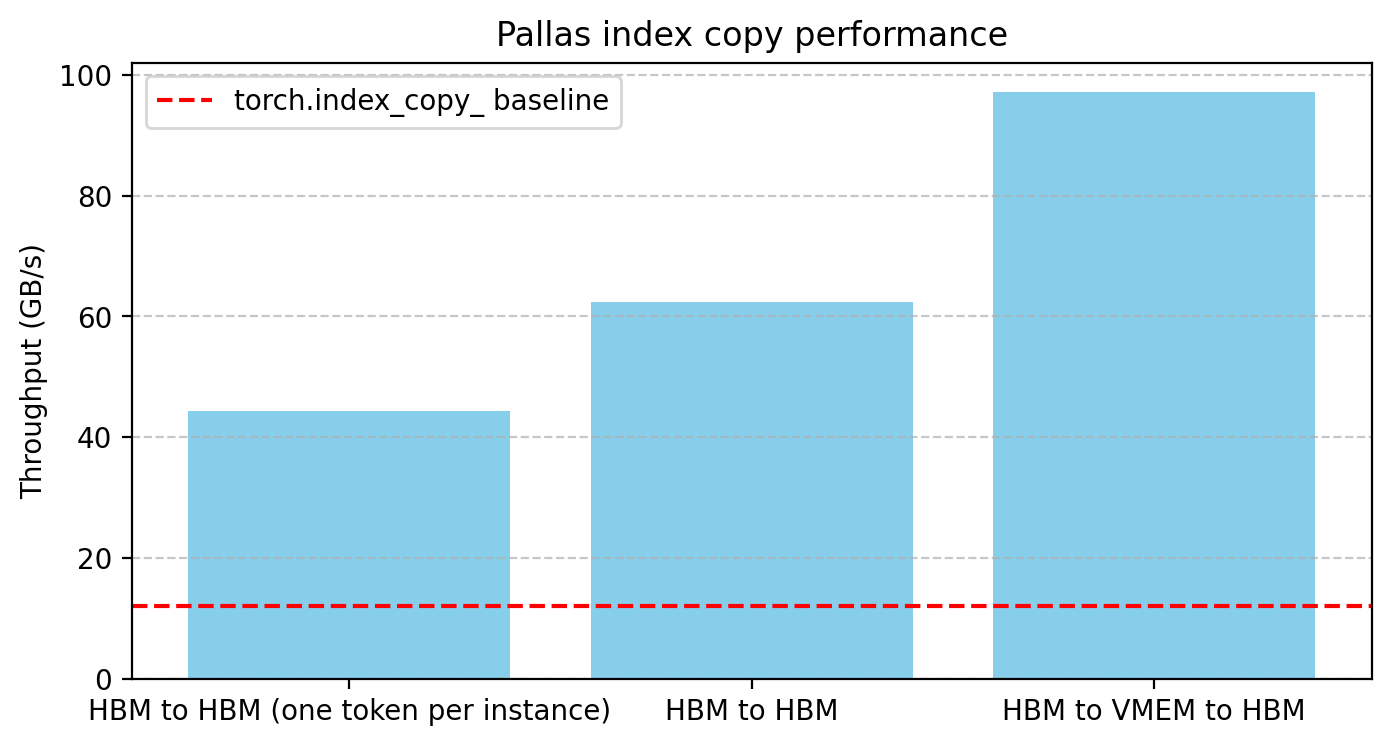

In [13]:
# Plot the results
def plot(pallas_perf):
  kernel_names = list(pallas_perf.keys())
  latencies = [v / 1e9 for v in pallas_perf.values()]

  plt.figure(figsize=(8, 4))
  plt.bar(kernel_names, latencies, color='skyblue')
  plt.ylabel('Throughput (GB/s)')
  plt.title('Pallas index copy performance')
  plt.xticks()
  plt.grid(axis='y', linestyle='--', alpha=0.7)

  # Add torch index copy as a red dotted line
  torch_index_copy_throughput = throughput_4 / 1e9  # Convert to GB/s
  plt.axhline(torch_index_copy_throughput, color='red', linestyle='--', label='torch.index_copy_ baseline')
  plt.legend()

plot(pallas_perf)

DMA-ing from HBM to VMEM and then to HBM is faster than HBM-to-HBM DMA! In other
words, we can trade VMEM usage for faster memory copies.

Interestingly, the performance is also better when we launch a single Pallas
program instance to copy all 2048 tokens, compared to launching one instance
to start/wait the DMA for a single token, over a grid of 2048 program instances.
There's likely some overhead associated with the use of a grid.

## vLLM pallas KV cache update kernel

Now we'll import and iterate on the KV cache update kernel in vLLM.

In [ ]:
# Taken from https://github.com/vllm-project/vllm/blob/7f280d69c98e560427d2cbc9c3c3c13a83510dca/vllm/attention/ops/pallas_kv_cache_update.py#L4

# SPDX-License-Identifier: Apache-2.0
# SPDX-FileCopyrightText: Copyright contributors to the vLLM project

import functools

import jax
from jax.experimental import pallas as pl   # noqa: F811
from jax.experimental.pallas import tpu as pltpu


def _kv_cache_update_kernel(
    # Prefetch
    slices_ref,  # [3, num_slices], tuple of (kv_cache_start, new_kv_start, slice_len)
    # Input
    new_kv_hbm_ref,  # [num_tokens, num_combined_kv_heads, head_dim]
    kv_cache_hbm_ref,  # [total_num_pages * page_size, num_combined_kv_heads, head_dim]
    # Output
    _,  # [total_num_pages * page_size, num_combined_kv_heads, head_dim]
    # Scratch
    scratch,  # [num_slices_per_block, page_size, num_combined_kv_heads, head_dim]
    sem,
):
    async_copies = []
    block_idx = pl.program_id(0)
    num_slices_per_block = scratch.shape[0]

    # Copy from new_kv_hbm_ref to scratch
    for i in range(num_slices_per_block):
        offset_i = i + block_idx * num_slices_per_block
        new_kv_start = slices_ref[1, offset_i]
        length = slices_ref[2, offset_i]
        async_copy = pltpu.make_async_copy(
            new_kv_hbm_ref.at[pl.ds(new_kv_start, length), ...],
            scratch.at[i, pl.ds(0, length), ...],
            sem,
        )
        async_copy.start()
        async_copies.append(async_copy)

    for async_copy in async_copies:
        async_copy.wait()

    # Copy from scratch to kv_cache_hbm_ref
    async_copies.clear()
    for i in range(num_slices_per_block):
        offset_i = i + block_idx * num_slices_per_block
        kv_cache_start = slices_ref[0, offset_i]
        length = slices_ref[2, offset_i]
        async_copy = pltpu.make_async_copy(
            scratch.at[i, pl.ds(0, length), ...],
            kv_cache_hbm_ref.at[pl.ds(kv_cache_start, length), ...],
            sem,
        )
        async_copy.start()
        async_copies.append(async_copy)
    for async_copy in async_copies:
        async_copy.wait()


@functools.partial(
    jax.jit,
    donate_argnums=(2,),
    static_argnames=["page_size", "num_slices_per_block"],
)
def kv_cache_update(
    new_kv: jax.Array,  # [total_num_token, num_combined_kv_heads, head_dim]
    slices: jax.Array,  # [3, slices], list of (kv_cache_start, new_kv_start, slice_len)
    kv_cache: jax.Array,  # [total_num_pages * page_size, num_combined_kv_heads, head_dim]
    *,
    page_size: int = 64,
    num_slices_per_block: int = 8,
):
    assert slices.shape[1] % num_slices_per_block == 0, f"Number of slices {slices.shape[1]} must be divisible by num_slices_per_block {num_slices_per_block}"
    _, num_combined_kv_heads, head_dim = new_kv.shape
    assert kv_cache.shape[1] == num_combined_kv_heads, f"head dimension mismatch: {kv_cache.shape[1]} vs {num_combined_kv_heads}"
    assert kv_cache.shape[2] == head_dim
    assert head_dim % 128 == 0
    # TODO: Add dynamic check to make sure that the all the slice lengths are
    # smaller or equal to page_size

    in_specs = [
        pl.BlockSpec(memory_space=pltpu.MemorySpace.ANY),
        pl.BlockSpec(memory_space=pltpu.MemorySpace.ANY),
    ]

    out_specs = [pl.BlockSpec(memory_space=pltpu.MemorySpace.ANY)]
    out_shape = [jax.ShapeDtypeStruct(kv_cache.shape, dtype=kv_cache.dtype)]

    scalar_prefetches = [slices]
    scratch = pltpu.VMEM(
        (num_slices_per_block, page_size, num_combined_kv_heads, head_dim),
        new_kv.dtype,
    )

    scratch_shapes = [
        scratch,
        pltpu.SemaphoreType.DMA,
    ]

    kernel = pl.pallas_call(
        _kv_cache_update_kernel,
        grid_spec=pltpu.PrefetchScalarGridSpec(
            num_scalar_prefetch=len(scalar_prefetches),
            in_specs=in_specs,
            out_specs=out_specs,
            grid=(slices.shape[1] // num_slices_per_block, ),
            scratch_shapes=scratch_shapes,
        ),
        out_shape=out_shape,
        input_output_aliases={len(scalar_prefetches) + 1: 0},
    )

    return kernel(*scalar_prefetches, new_kv, kv_cache)[0]

In [15]:
# Benchmarking harness
from dataclasses import dataclass
import jax
import jax.numpy as jnp
import numpy as np

@dataclass
class Fixture:
  kv_cache: jax.Array
  new_kv: jax.Array
  slot_mapping: jax.Array
  slices: jax.Array

def make_fixture() -> Fixture:
  kv_cache = jnp.asarray(np.random.rand(KV_CACHE_NUM_BLOCKS, BLOCK_SIZE, 4, HEAD_SIZE)).astype(jnp.bfloat16)
  new_kv = jnp.asarray(np.random.rand(NUM_TOKENS_BENCH, 4, HEAD_SIZE)).astype(jnp.bfloat16)
  # Generate slot mapping of representative sizes:
  # 1024 prefill tokens, 512 prefill tokens, 512 decode tokens.
  # slot locations: [0-1023], [2048-2559], [512 random indices between 3000-5000]
  slices = []
  # kv_cache_start, new_kv_start, slice_len
  new_kv_start = 0
  for i in range(0, 1024, BLOCK_SIZE):
    slices.append(jnp.array([0 + i, new_kv_start, BLOCK_SIZE], dtype=jnp.int32))
    new_kv_start += BLOCK_SIZE
  for i in range(0, 512, BLOCK_SIZE):
    slices.append(jnp.array([2048 + i, new_kv_start, BLOCK_SIZE], dtype=jnp.int32))
    new_kv_start += BLOCK_SIZE
  # Generate 512 random indices between 3000 and 5000
  key = jax.random.PRNGKey(0)
  random_indices = jax.random.randint(key, (512,), 3000, 5000)
  for i in range(512):
    kv_cache_start = random_indices[i]
    slice_len = 1
    slices.append(jnp.array([kv_cache_start, new_kv_start, slice_len], dtype=jnp.int32))
    new_kv_start += slice_len
  assert new_kv_start == NUM_TOKENS_BENCH, "new_kv_start should match the number of tokens benchmarked"
  assert new_kv_start <= kv_cache.shape[0], "new_kv_start should not exceed kv_cache size"
  slices = jnp.stack(slices, axis=0)
  # Round up to a multiple of 8 slices
  num_slices = len(slices)
  num_slices_rounded = (num_slices + 7) // 8 * 8
  slices = jnp.pad(slices, ((0, num_slices_rounded - num_slices), (0, 0)), mode='constant', constant_values=0)
  # Derive the slot mapping based on slices
  slot_mapping = np.zeros(NUM_TOKENS_BENCH, dtype=np.int32)
  for i in range(slices.shape[0]):
    kv_cache_start, new_kv_start, slice_len = slices[i, :]
    slot_mapping[new_kv_start:new_kv_start + slice_len] = np.arange(kv_cache_start, kv_cache_start + slice_len)
  return Fixture(
      kv_cache=kv_cache,
      new_kv=new_kv,
      slot_mapping=jnp.array(slot_mapping, dtype=jnp.int32),
      slices=slices.transpose().astype(jnp.int32),
  )

@partial(jax.jit, donate_argnums=(0,))
def sliced_copy(kv_cache, new_kv, slot_mapping, slices):
  num_blocks = kv_cache.shape[0]
  block_size = kv_cache.shape[1]
  flat_kv_cache = kv_cache.reshape(-1, *kv_cache.shape[2:])
  flat_kv_cache = kv_cache_update(new_kv, slices, flat_kv_cache, page_size=BLOCK_SIZE)
  return flat_kv_cache.reshape(num_blocks, block_size, *kv_cache.shape[2:])

In [24]:
def benchmark_index_copy(copier):
  print(f"Running benchmark for {copier.__name__}...")
  fixture = make_fixture()
  gc.collect()
  all_outputs = []
  jax.block_until_ready(jax.live_arrays())
  NUM_STEPS = 10
  PROFILE_DIR = 'profile/index_copy_pallas'
  os.makedirs(PROFILE_DIR, exist_ok=True)
  slot_mapping = fixture.slot_mapping
  new_kv = fixture.new_kv
  slices = fixture.slices
  kv_caches = [fixture.kv_cache.copy() for _ in range(NUM_STEPS)]
  # Warm up
  jax.block_until_ready(copier(jnp.asarray(np.random.rand(KV_CACHE_NUM_BLOCKS, BLOCK_SIZE, 4, HEAD_SIZE)).astype(jnp.bfloat16), new_kv, slot_mapping, slices))
  # Start profiling
  jax.profiler.start_trace(PROFILE_DIR)
  for i in range(NUM_STEPS):
    all_outputs.append(copier(kv_caches[i], new_kv, slot_mapping, fixture.slices))
  jax.block_until_ready(all_outputs)
  jax.profiler.stop_trace()
  step_time = step_duration_from_latest_profile(PROFILE_DIR, ignore_gaps=True, verbose=False)
  bytes_copied = new_kv.size * new_kv.dtype.itemsize
  print(f"Execution took {step_time * 1000:.4f} ms. Bytes copied: {bytes_copied} bytes.")
  throughput = bytes_copied / step_time
  print(f"Throughput: {throughput / 1e9:.2f} GB/s.")
  return throughput

realistic_pallas_perf = {}
realistic_pallas_perf["8 slice"] = benchmark_index_copy(sliced_copy)
gc.collect()

Running benchmark for sliced_copy...
Execution took 0.0741 ms. Bytes copied: 2097152 bytes.
Throughput: 28.30 GB/s.


0

## Performance comparison

In [25]:
# Compare with earlier Pallas kernels
def individual_token_copy(kv_cache, new_kv, slot_mapping, slices):
  return pallas_index_copy(kv_cache, new_kv, slot_mapping)

def single_program_hbm_copy(kv_cache, new_kv, slot_mapping, slices):
  return pallas_index_copy_hbm(kv_cache, new_kv, slot_mapping)

def single_program_vmem_copy(kv_cache, new_kv, slot_mapping, slices):
  return pallas_index_copy_vmem(kv_cache, new_kv, slot_mapping)

realistic_pallas_perf["1 token"] = benchmark_index_copy(individual_token_copy)
realistic_pallas_perf["2048 token\n(HBM DMA)"] = benchmark_index_copy(single_program_hbm_copy)
realistic_pallas_perf["2048 token\n(VMEM DMA)"] = benchmark_index_copy(single_program_vmem_copy)
gc.collect()

Running benchmark for individual_token_copy...
Execution took 0.0471 ms. Bytes copied: 2097152 bytes.
Throughput: 44.55 GB/s.
Running benchmark for single_program_hbm_copy...
Execution took 0.0337 ms. Bytes copied: 2097152 bytes.
Throughput: 62.31 GB/s.
Running benchmark for single_program_vmem_copy...
Execution took 0.0216 ms. Bytes copied: 2097152 bytes.
Throughput: 97.13 GB/s.


0

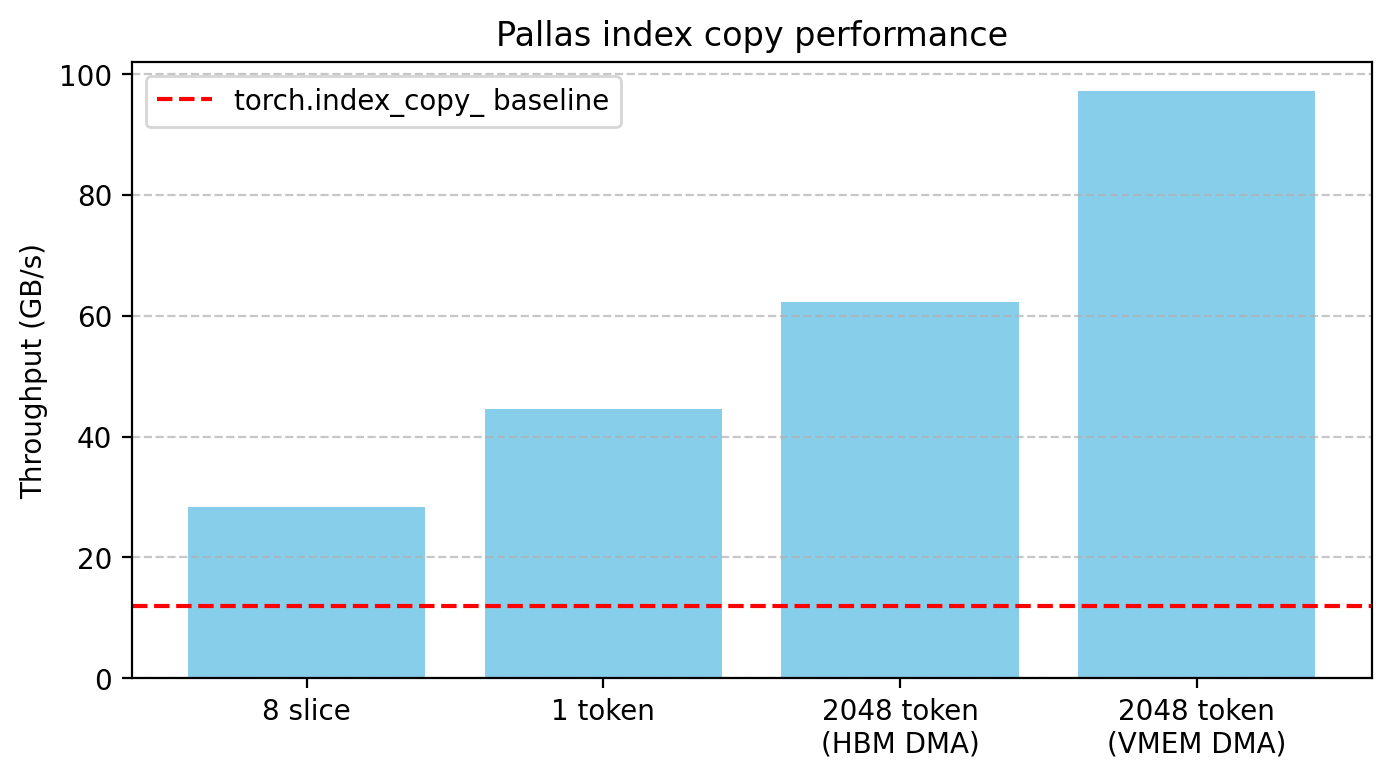

In [26]:
plot(realistic_pallas_perf)